In [2]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.engine import training
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import h5py
import numpy
import glob
import numpy as np
import pathlib
import timeit
import enum
import matplotlib.pyplot as plt
import seaborn as sns
from ast import FunctionDef
from enum import Enum
from glob import glob
import pandas as pd
import sklearn
import os
import logging, sys
import glob
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())
# See TensorFlow version
print(tf.__version__)
# Configure the logger with basic debug configuration
logging.basicConfig(stream=sys.stderr, level=logging.INFO)
class DeepLearningModels(Enum):
    InceptionV3 = 'InceptionV3'
    VGG16 = 'VGG-16'
    VGG19 = 'VGG-19'
    GoogLeNet = 'GoogLeNet'
    AlexNet = 'AlexNet'
    ResNet50V2 = 'ResNet-50V2'
    ResNet101 = 'ResNet-101V2'
    CutomNet = 'CustomNet'
class Optimizers(Enum):
    SGD = 'SGD'
    Adamax = 'Adamax'
    RMSProp = 'RMSProp'
class Epochs(Enum):
    _25 = 25
    _50 = 50
    _100 = 100
class LearningRates(Enum):
    lr_10e3 = 1e-3
    lr_10e4 = 1e-4
    lr_10e5 = 1e-5
    lr_10e6 = 1e-6
class KFolds(Enum):
    fold1 = 'fold1'
    fold2 = 'fold2'
    fold3 = 'fold3'
    fold4 = 'fold4'
    fold5 = 'fold5'
class ModelData:
    model: DeepLearningModels
    optimizer: Optimizers
    epoch: Epochs
    learning_rate: LearningRates
    fold: KFolds
    accuracy: float

    src_path: str
    dst_path: str

    src_file_name: str
    dst_file_name: str

    def __init__(self, model: DeepLearningModels, optimizer: Optimizers, epoch: Epochs, learning_rate: LearningRates,
                 fold: KFolds, accuracy: float):
        self.model = model
        self.optimizer = optimizer
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.fold = fold
        self.accuracy = accuracy
enum_map = {'inception': DeepLearningModels.InceptionV3.value,
            'resnet50': DeepLearningModels.ResNet50V2.value,
            'SGD': Optimizers.SGD.value,
            'adamax': Optimizers.Adamax.value,
            'RMSprop': Optimizers.RMSProp.value,
            '25': Epochs._25.value,
            '50': Epochs._50.value,
            '100': Epochs._100.value,
            '1e-06': LearningRates.lr_10e6.value,
            '1e-05': LearningRates.lr_10e5.value,
            '0.0001': LearningRates.lr_10e4.value,
            '0.001': LearningRates.lr_10e3.value,
            'fold1': KFolds.fold1.value,
            'fold2': KFolds.fold2.value,
            'fold3': KFolds.fold3.value,
            'fold4': KFolds.fold4.value,
            'fold5': KFolds.fold5.value
            }
model_directory = "data/models"
logging.info(f"Look into {model_directory} for saved Keras Models ")
def save_predictions(predictions, labels, model_path, model_data):
    csv_path = str(str(model_path) + '/' +str(model_data.model) + '_' +str(model_data.optimizer) + '_' +str(model_data.epoch) + '_' +str(model_data.learning_rate) + '_' +str(model_data.fold) + '.csv')
    logging.info(f'Prediction csv file is {csv_path}')


    df_labels = numpy.asarray(labels)
    df_predictions = numpy.asarray(predictions)

    data = {'y_actual': labels,
            'y_predicted': predictions
            }

    df_confusion_matrix = pd.DataFrame(data, columns=[df_labels, df_predictions])

    pd.DataFrame(df_confusion_matrix).to_csv(csv_path)
    logging.info(f'{csv_path} file is created....')
def decodeModel(model_path):
    items = model_path.split('_')
    model_enum = enum_map.get(items[1])
    optimizer = enum_map.get(items[2])
    epoch = enum_map.get(items[3])
    learning_rate = enum_map.get(items[4])
    fold = enum_map.get(items[5])
    accuracy = 0
    model_data = ModelData(model_enum, optimizer, epoch, learning_rate, fold, accuracy)
    logging.info(f'Model paremeters are : {vars(model_data)}')

    valid_path = f'DB3/{fold}/test/images'
    logging.info(f'Test images folder is  {valid_path}')

    test_set = ImageDataGenerator(rescale=1. / 255).flow_from_directory(valid_path,
                                                                        target_size=(224, 224),
                                                                        batch_size=32,
                                                                        class_mode='categorical',
                                                                        )
    logging.info(
        f'Loaded test images as array of batches into test_set variable having a length: ' + str(len(test_set)))

    input(f'👉 Press Enter to load keras model from path {model_path}')

    # Recreate the exact same model, including its weights and the optimizer
    model = tf.keras.models.load_model(model_path)

    # Check its architecture and show
    model.summary()

    logging.info('✅ model.summary() executed successfully...')

    input("👉 Press Enter to Evaluate test_set!!!!")

    # Evaluate the restored model
    loss, acc = model.evaluate(test_set, steps=len(test_set))
    model_data.accuracy = round((acc * 100), 2)
    logging.info("✅ Restored model, accuracy: {:5.2f}%".format(100 * acc))

    confusion_labels = []
    # Traverse all the images and store their labels
    for name in os.listdir(valid_path):  # drive'a eklenme sırasında döndürüyor
        confusion_labels.append(name)

    logging.info(f"Labels of confusion matrix are {confusion_labels=}")

    input("👉 Press Enter to start predictions over the image batches of test_set:   model.predict(test_set[i])")

    all_predictions = np.array([])
    all_labels = np.array([])

    logging.info(f"Starting to loop over batches of test_set. #of image batches is {str(len(test_set))} ")

    for i in range(len(test_set)):
        test_images, test_labels = test_set[i]

        predictions = model.predict(test_images)
        logging.info(f"Prediction completed over the image batch [{i}]")

        predictions = np.argmax(predictions, axis=1)
        labels = np.argmax(test_labels, axis=1)

        all_predictions = np.concatenate([all_predictions, predictions])
        all_labels = np.concatenate([all_labels, labels])
    logging.info(f"✅ Finished predictions successfully...")

    input("👉 Press enter to save predictions to csv file")
    save_predictions(all_predictions, all_labels, model_path, model_data)
    with open('label{}.npy'.format(model_data.fold), 'wb') as l:
        np.save(l,all_labels)
    with open('pred{}.npy'.format(model_data.fold), 'wb') as p:
        np.save(p,all_predictions)
    # with open('label.npy', 'rb') as l:
    #     i = np.load(l)
    # with open('pred.npy', 'rb') as p:
    #     u = np.load(p)
    print(len(all_predictions))
    print(len(all_labels))
    print(all_labels,all_predictions)
    input("👉 Press enter to create confusion_matrix")
    # create confusion_matrix
    confusion_matrix = tf.math.confusion_matrix(all_labels, all_predictions)
    # Initialize for plotting the figure of confusion_matrix

    confusion_matrix_title = f'{vars(model_data)}'
    plt.clf()
    plt.figure(figsize=(13, 7))

    sns.heatmap(confusion_matrix,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 13},
                xticklabels=sorted(confusion_labels),
                yticklabels=sorted(confusion_labels))

    plt.ylabel('Predictions')
    plt.xlabel('Actuals')
    plt.title(confusion_matrix_title)

    figure_path = str(str(model_path) + '/' +str(model_data.model) + '_' +str(model_data.optimizer) + '_' +str(model_data.epoch) + '_' +str(model_data.learning_rate) + '_' +str(model_data.fold) + '_' +str(model_data.accuracy) + '%.png')

    plt.savefig(figure_path,
                format="png",
                dpi=300,
                bbox_inches='tight')

    logging.info(f"✅ Confusion_matrix figure saved successfully...  to file {figure_path=} ")

    plt.show()


# Traverse all saved models
for entry in os.scandir(model_directory):

    logging.info(f"Saved model name is : {entry.name}")
    # check the name of saved model if it starts with undescore '_'
    if (entry.name.startswith('_')):
        # filter the saved content if there exists data file named like variables.data_1111101111
        variables = glob.glob(f'{model_directory}/{entry.name}/variables/variables.data*')
        if (len(variables) > 0):
            logging.info(f'Found data file: {variables[0]} and calling the function: decodeModel()')
            # call decodeModel function given the parameter of saved model's full path
            decodeModel(f"{model_directory}/{entry.name}")

INFO:root:Look into data/models for saved Keras Models 
INFO:root:Saved model name is : _Densenet_25_RMSProp_0.0001_fold1
INFO:root:Found data file: data/models/_Densenet_25_RMSProp_0.0001_fold1/variables\variables.data-00000-of-00001 and calling the function: decodeModel()
INFO:root:Model paremeters are : {'model': None, 'optimizer': 25, 'epoch': None, 'learning_rate': 0.0001, 'fold': 'fold1', 'accuracy': 0}
INFO:root:Test images folder is  DB3/fold1/test/images
INFO:root:Loaded test images as array of batches into test_set variable having a length: 29


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.1
Found 900 images belonging to 30 classes.
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/con

INFO:root:✅ model.summary() executed successfully...


24/29 [=======================>......] - ETA: 3s - loss: 0.7677 - accuracy: 0.8086

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001E26AE19AB0>
Traceback (most recent call last):
  File "C:\Users\gnrno\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\c_api_util.py", line 55, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 

KeyboardInterrupt



In [19]:
import random
sayi1 = 0
sayi2 = 0
lastNum = 100
while sayi1 < 100 and sayi2 < 100:
    say1 = random.randint(1,6)
    sayi1 = sayi1 + say1
    say2 = random.randint(1,6)
    sayi2 = sayi2 + say2
    print(sayi2)
    print(sayi1)
    print("dsdd")



2
3
dsdd
3
4
dsdd
7
9
dsdd
8
10
dsdd
12
12
dsdd
18
16
dsdd
22
17
dsdd
23
21
dsdd
29
22
dsdd
30
28
dsdd
34
33
dsdd
40
38
dsdd
44
44
dsdd
45
47
dsdd
46
52
dsdd
51
55
dsdd
57
57
dsdd
58
62
dsdd
64
65
dsdd
66
71
dsdd
72
72
dsdd
78
73
dsdd
82
74
dsdd
87
80
dsdd
93
85
dsdd
99
88
dsdd
105
91
dsdd


In [22]:
penalty1 = 123
penalty2 = 121
sayi1 = 12
if sayi1 == penalty1 or sayi1== penalty2:
    print("yes")
else:
    print("not")


not


In [3]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3

from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.engine import training
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import h5py
import numpy
import glob
import numpy as np
import pathlib
import timeit
import enum
import matplotlib.pyplot as plt
import seaborn as sns
from ast import FunctionDef
from enum import Enum
from glob import glob
import pandas as pd
import sklearn
import os
import logging, sys
import glob
labels = np.array([])
predictions = np.array([])
for i in range(5):
    with open('labelfold{}.npy'.format(i+1), 'rb') as l:
        y = np.load(l)
        #print(y)
        labels = np.append(labels,y)
        #print(len(labels))
    with open('predfold{}.npy'.format(i+1), 'rb') as p:
        u = np.load(p)
        #print(u)
        predictions = np.append(predictions,u)
        #print(len(predictions))
print(labels)
print(len(labels))
print(predictions)
print(len(predictions))

[ 9. 15.  7. ... 29. 23. 29.]
4500
[ 9. 18.  7. ... 29. 23. 29.]
4500


In [16]:
# labeller = ["sunflowerseeds_black_unsalted", "almond_kernel"," almond_roasted","broadbean_shell","kidneybeans_cherries","pepper_isot", "bulgur_rice", "black_cumin", "dried_mulberry", "bean_dermason", "bean_mas","bean_sugar", "nuts_roasted",
# "peanut_shell", "palm_medjoul", "fig_natural", "pumpkin_seeds_unsalted", "cashew_roasted", "dried_apricots_yellow","cocktail_luxury","chickpeas_sugar_white", "lemonsalt_grain", "turkishdelight_pistachio_double", "red_lentils_football", "large_chickpeas_white","rice_baldo", "rice_osmancik", "rice_yerli_pilav", "cinnamon_powder", "turmeric_powder"]
# print(len(labeller))

30


In [23]:
def polyShow(poly_list):
    compntsNum = len(poly_list)
    for i in range(compntsNum):
        return str(poly_list[i][1]) + "x" + str(poly_list[i][0])



polyShow([[54,65],[3,4]])

'65x54'

['aycekirdek_siyah_tuzsuz', 'badem_ici', 'badem_kavrulmus', 'bakla_kabuklu', 'barbunya_kiraz', 'biber_isot', 'bulgur_pilavlik', 'corekotu', 'dut_kurusu', 'fasulye_dermason', 'fasulye_mas', 'fasulye_seker', 'findik_kavrulmus', 'fistik_kabuklu', 'hurma_medjoul', 'incir_naturel', 'kabak_tuzsuz', 'kaju_kavrulmus', 'kayisi_sari', 'kokteyl_luks', 'leblebi_seker_beyaz', 'limon_tuzu_tane', 'lokum_fistikli_duble', 'mercimek_kirmizi_futbol', 'nohut_iri_beyaz', 'pirinc_baldo', 'pirinc_osmancik', 'pirinc_yerli_pilavlik', 'tarcin_toz', 'zerdecal_toz']


<Figure size 432x288 with 0 Axes>

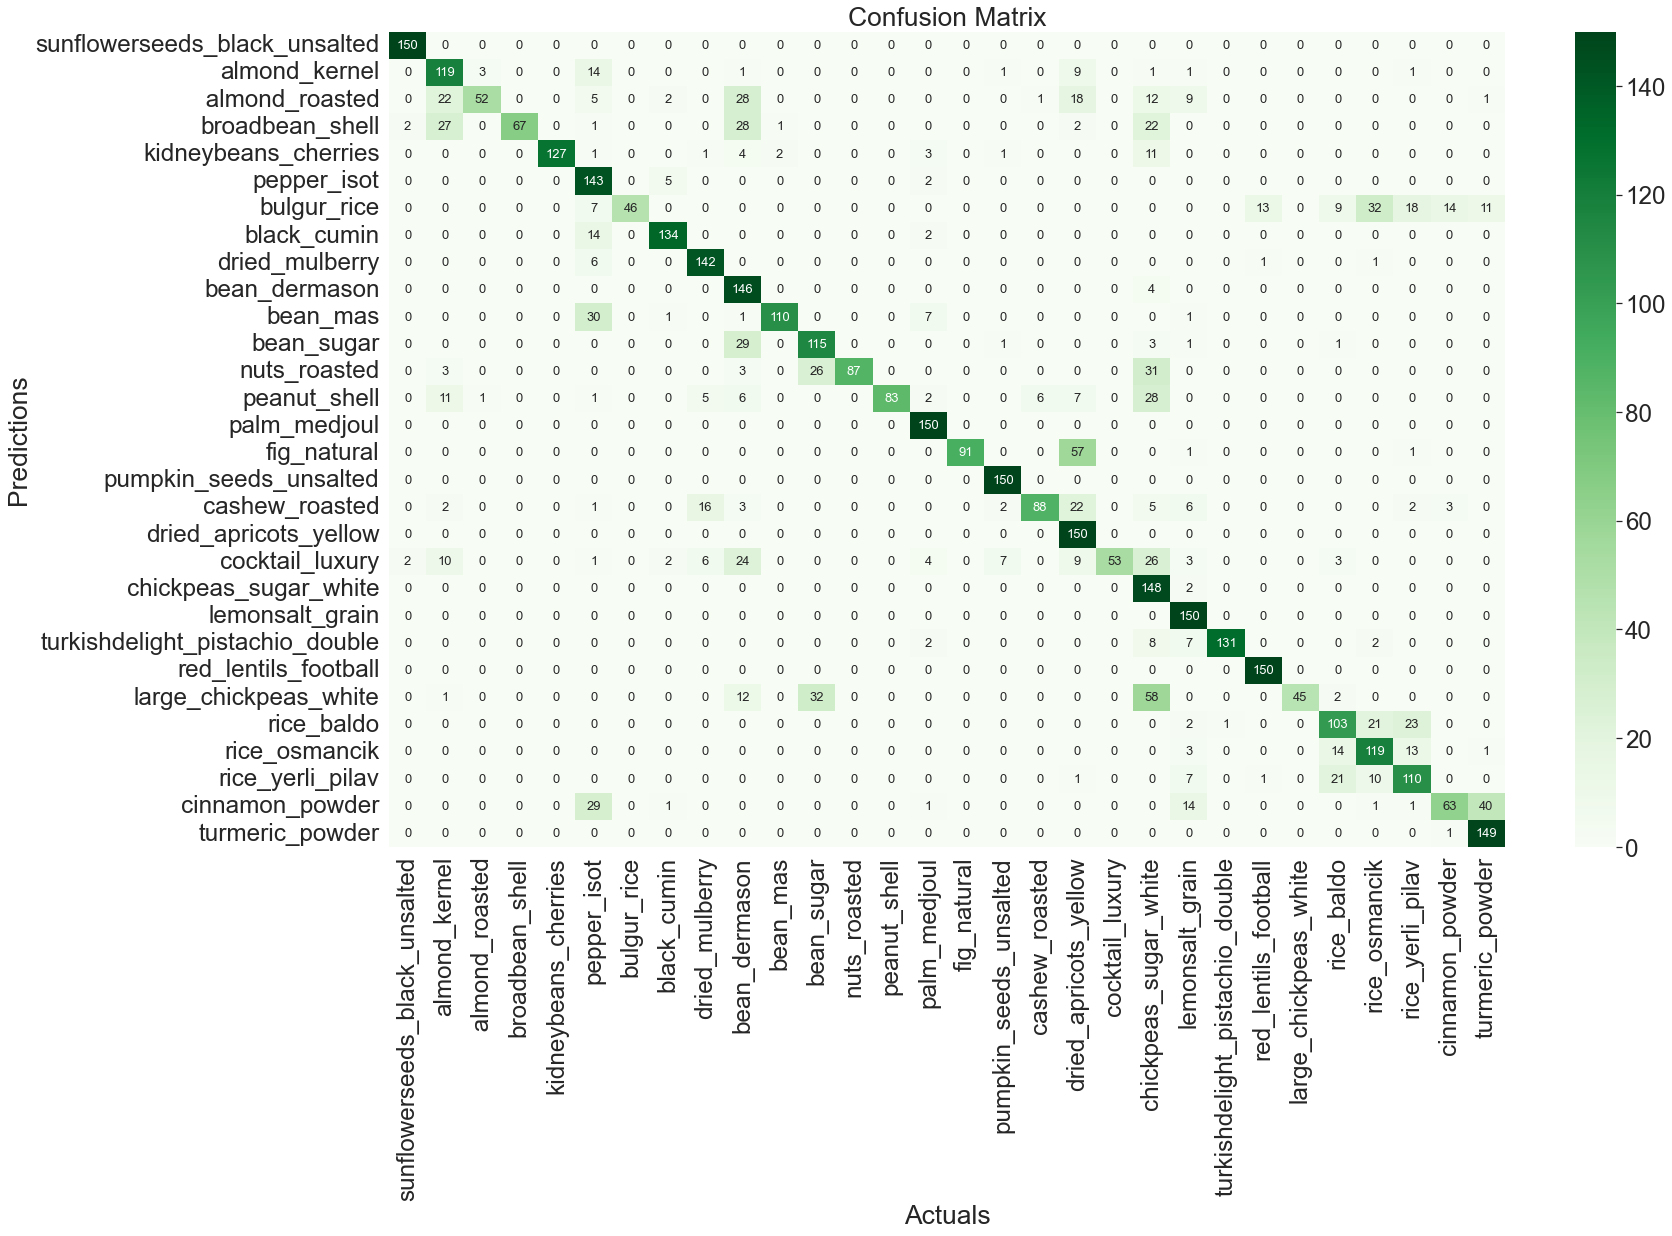

In [5]:
;import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.engine import training
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import h5py
import numpy
import glob
import numpy as np
import pathlib
import timeit
import enum
import matplotlib.pyplot as plt
import seaborn as sns
from ast import FunctionDef
from enum import Enum
from glob import glob
import pandas as pd
import sklearn
import os
import logging, sys
import glob

confusion_matrix = tf.math.confusion_matrix(labels, predictions)
    # Initialize for plotting the figure of confusion_matrixf
confusion_labels=[]
for name in os.listdir("DB3/fold1/test/images"):  #drive'a eklenme sırasında döndürüyor
    confusion_labels.append(name)
print(confusion_labels)
confusion_matrix_title = "Confusion Matrix"
labeller = ["sunflowerseeds_black_unsalted", "almond_kernel"," almond_roasted","broadbean_shell","kidneybeans_cherries","pepper_isot", "bulgur_rice", "black_cumin", "dried_mulberry", "bean_dermason", "bean_mas","bean_sugar", "nuts_roasted",
"peanut_shell", "palm_medjoul", "fig_natural", "pumpkin_seeds_unsalted", "cashew_roasted", "dried_apricots_yellow","cocktail_luxury","chickpeas_sugar_white", "lemonsalt_grain", "turkishdelight_pistachio_double","red_lentils_football", "large_chickpeas_white","rice_baldo", "rice_osmancik", "rice_yerli_pilav", "cinnamon_powder", "turmeric_powder"]
plt.clf()
plt.figure(figsize=(25,15))
sns.set(font_scale =2.2)
sns.heatmap(confusion_matrix,fmt="g",
            annot=True,
            annot_kws={'fontsize': 13},
            cmap='Greens',
            #xticklabels=confusion_labels,
            #yticklabels=confusion_labels,
            xticklabels=labeller,
            yticklabels=labeller)

plt.ylabel('Predictions')
plt.xlabel('Actuals')
plt.title(confusion_matrix_title)

plt.savefig("data/models/eng.jpeg",
            format="png",
            dpi=300,
            bbox_inches='tight')

plt.show()

In [6]:
import sklearn.metrics
print(sklearn.metrics.classification_report(labels,predictions))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       150
         1.0       0.61      0.79      0.69       150
         2.0       0.93      0.35      0.50       150
         3.0       1.00      0.45      0.62       150
         4.0       1.00      0.85      0.92       150
         5.0       0.57      0.95      0.71       150
         6.0       1.00      0.31      0.47       150
         7.0       0.92      0.89      0.91       150
         8.0       0.84      0.95      0.89       150
         9.0       0.51      0.97      0.67       150
        10.0       0.97      0.73      0.84       150
        11.0       0.66      0.77      0.71       150
        12.0       1.00      0.58      0.73       150
        13.0       1.00      0.55      0.71       150
        14.0       0.87      1.00      0.93       150
        15.0       1.00      0.61      0.76       150
        16.0       0.93      1.00      0.96       150
        17.0       0.93    

In [23]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from pkg_resources import *
driver = webdriver.Chrome()
driver.get("https://www.amazon.fr/dp/B0886GYSSD")
al = driver.find_element(by=By.ID, value="prodDetails").text
liste = [al.split("\n")]
sonlist = []
for a in liste:
    for i in a:
        sonlist.append(i)
for i in sonlist:
    # print(i
    if "évaluations" in i:
        print(sonlist)
        print(i)

        sonlist.remove(i)
        print(sonlist)
        reviewNumber = i.replace(" évaluations", "")
        # print(reviewNumber)
        # print(type(reviewNumber))
        reviewNumber = int(reviewNumber)
        # print(reviewNumber)
        # print(type(reviewNumber))
        #
        # print(sonlist)
        # print(int(reviewNumber))
    # if "évaluation" in i:
    #     print(i)
    #     reviewNumber = i.replace(" évaluation", "")
    #     print(reviewNumber)
    #     print(type(reviewNumber))
    #     reviewNumber = int(reviewNumber)
    #     print(reviewNumber)
    #     print(type(reviewNumber))
    #     # print(int(reviewNumber))



['Informations sur le produit', 'Descriptif technique', 'Fabricant Rizline', 'Marque Rizline', 'Modèle Golf', "Poids de l'article 3.24 kg", 'Dimensions du produit (L x l x h) 80 x 50 x 5 cm; 3.24 kilogrammes', 'Référence constructeur rzfs_24', 'Numéro de série fabricant Rzfs_24', 'Position Interne', 'Caractéristiques spécifiques Élastique, Antidérapant, Imperméable, Inodore', 'Informations complémentaires', 'ASIN B0886GYSSD', 'Moyenne des commentaires client', '318 évaluations', '4,5 sur 5 étoiles', "Classement des meilleures ventes d'Amazon 73,674 en Auto et Moto (Voir les 100 premiers en Auto et Moto)", '1,785 en Tapis de sol', 'Date de mise en ligne sur Amazon.fr 13 mai 2020', 'Votre avis', 'Voulez-vous nous parler de prix plus bas?']
318 évaluations
['Informations sur le produit', 'Descriptif technique', 'Fabricant Rizline', 'Marque Rizline', 'Modèle Golf', "Poids de l'article 3.24 kg", 'Dimensions du produit (L x l x h) 80 x 50 x 5 cm; 3.24 kilogrammes', 'Référence constructeur rz

In [5]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from pkg_resources import *
options = Options()
options.add_argument("--start-maximized")
prefs = {"profile.managed_default_content_settings.images": 2}
options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(options=options)
driver.get("https://www.amazon.co.uk/dp/B08BYR123L")

In [1]:
link = "https://www.amazon.co.uk/dp/B08BYR123L"
l = link.split("/")
sonASIN = l[-1]
print(sonASIN)

B08BYR123L


In [9]:
per1 = 14
per2 = 0
per3 = 0
per4 = 0
per5 = 86
person = per1*1 + per2*2 + per3*3 + per4*4 + per5*5
personn = person/100
print(personn)
ula = "%.1f" %personn
ula = float(ula)
print(ula)
print(type(personn))
print(type(ula))

4.44
4.4
<class 'float'>
<class 'str'>
